In [1]:
#
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pickle


#from svc_train import build_svc_model
from sklearn.preprocessing import StandardScaler

#from utils_vehicles import *


# Preparation process for saved model and saved X / y training data set

In [2]:
def load_rf_model():

    # and later you can load it
    print("loading random forest model ....")

    with open('my_rf_classifier.pkl', 'rb') as f:
        rf = pickle.load(f)

    return rf


def load_model():

    # and later you can load it
    print("loading svc model ....")

    with open('my_svc_classifier.pkl', 'rb') as f:
        clf = pickle.load(f)

    return clf

def load_train_test():

    X_train = np.load("X_train.npy")
    X_test = np.load("X_test.npy")

    y_train = np.load("y_train.npy")
    y_test = np.load("y_test.npy")

    return X_train, X_test, y_train, y_test

In [3]:
#
# load model 
#
clf = load_model()
rf = load_rf_model()

loading svc model ....
loading random forest model ....


In [4]:
#
#
#
X_train, X_test, y_train, y_test = load_train_test()

print(" Scaling (Normalized data) ....")
# standarized (normalized data)
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)


 Scaling (Normalized data) ....


In [6]:
#
# testing saved model
#
print("LinearSVC model",clf.score(scaled_X_test, y_test))
print("Random Forest model",rf.score(scaled_X_test, y_test))

# model is based to use all channels

LinearSVC model 0.995777027027027
Random Forest model 0.9949324324324325


# Sliding Windows 

## loading test images data for finding car

In [7]:
test_base = "./test_images"

test_files = []
target_dir = os.path.join( test_base , "*")
files = glob.glob( target_dir  )
test_files.extend(files)

filenames = [f.split('/')[-1] for f in files ]

print("Number of Test Data ..", len(test_files))
print(filenames)

Number of Test Data .. 6
['test6.jpg', 'test5.jpg', 'test4.jpg', 'test1.jpg', 'test3.jpg', 'test2.jpg']


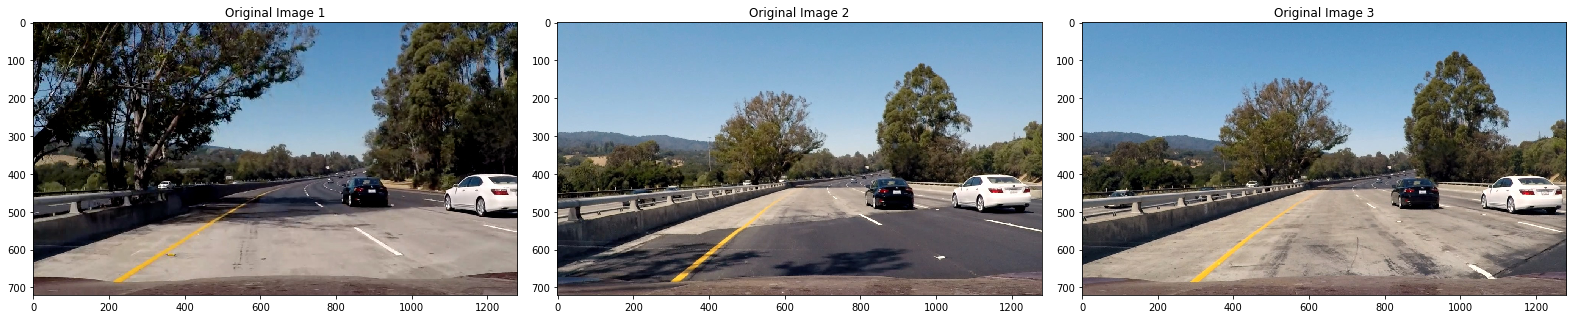

In [8]:
imread_ops = lambda im : imread(im)
test_images  = np.array( list( map( imread_ops , test_files  )))

fig = plt.figure(figsize=(22,12))
plt.subplot(131)
plt.imshow(test_images[1])
plt.title('Original Image 1')
plt.subplot(132)
plt.imshow(test_images[2])
plt.title('Original Image 2')
plt.subplot(133)
plt.imshow(test_images[3])
plt.title('Original Image 3')
fig.tight_layout()

In [8]:
test_images[0].shape

(720, 1280, 3)

## core algo to split image with small square window, so that car image is found in the box.

In [9]:
## function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    ## compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    ## generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    ## concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # return the individual histograms, bin_centers, and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [10]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    ## convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    
    ## use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    return features

In [11]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

In [12]:
## function to extract features from a single image
def single_img_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, color_feat=True, hog_feat=True):    
    
    ## define an empty list to receive features
    img_features = []
    
    ## apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    ## spatial features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    ## color features
    if color_feat:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
        
    ## HOG features
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        ## append features to list
        img_features.append(hog_features)

    ## return concatenated array of features
    return np.concatenate(img_features)

In [13]:
# sliding window algorythm 
#
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [14]:
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    color_feat=True, hog_feat=True):

    ## create an empty list to receive positive detection windows
    on_windows = []
    
    ## iterate over all windows in the list
    for window in windows:
        
        ## extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        ## extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            color_feat=color_feat, hog_feat=hog_feat)
        
        ## scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        ## predict using your classifier
        prediction = clf.predict(test_features)
        ## if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    ## return windows for positive detections
    return on_windows

In [15]:
## function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    ## make a copy of the image
    imcopy = np.copy(img)
    
    ## iterate through the bounding boxes
    for bbox in bboxes:
        
        ## draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy


## Test routine to build small window packets
***
It is iteration process to build small window boxes from road image file, which size is 96 128 and 192.
Splitted size becomes bigger near the bottom of image, because of we understand image perspective which depict the smaller objects as it located in far points of the landscape.

In [40]:
## create boundary for search
y_start_stop = [375, 640]
image = test_images[2]

## create windows to be searched
window_sizes = [96, 128, 192]
#window_sizes = [64, 96, 128]
overlap = [0.8, 0.7, 0.5]
colors = [(0,0,255),(0,255,255),(0,255,0)]
windows_img = np.copy(image)
windows = []


for idx, window_size in enumerate(window_sizes):
    ## find windows at different scales
    temp_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))
    
    ## adding the new windows
    windows += temp_windows

In [41]:
len(windows)

703

## draw default boxes on test image == 1191 boxes are on image

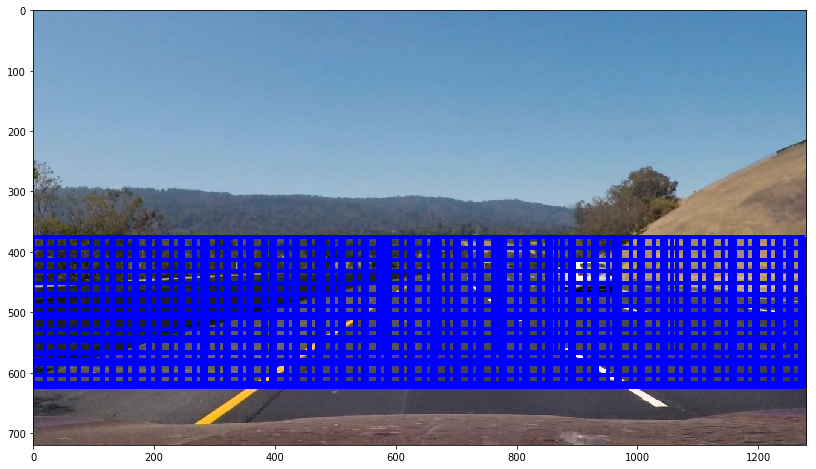

In [42]:
window_img = draw_boxes(test_images[4], windows, color=(0, 0, 255), thick=6)    
plt.figure(figsize=(14,8))
plt.imshow(window_img)

## Next, we search car image from splitted boxes where any objects having same data patterns of image features as car are placed, then keep memmory for window size data. 

/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


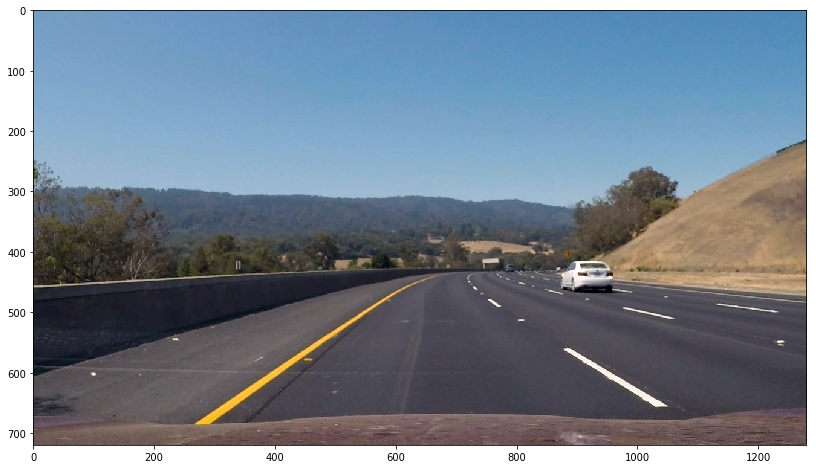

In [43]:
color_space="YCrCb"
## set parameters
y_start_stop = [375, 640]

X_scaler = X_scaler

orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True
image_orig = test_images[4]


## search windows and classify cars
hot_windows = search_windows(image_orig, windows, rf, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        color_feat=color_feat, hog_feat=hog_feat)                       

## draw boxes around possible cars
window_img = draw_boxes(image_orig, hot_windows)                    
plt.figure(figsize=(14,8))
plt.imshow(window_img)

## Search all test images to show how Random Forest classifier can detect car object from the rectangle boxes.

In [23]:
print(" test image size .." , test_images[0].shape)
print(" Start to seach car with sliding multiple window technique ....")
window_sizes = [64, 96, 156]

find_car_windows = []
for image in test_images:
    
    overlap = [0.9, 0.85, 0.8]

    window_list = []
    for idx, window_size in enumerate(window_sizes):
        ## find windows at different scales
        temp_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                               xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))

        ## adding the new windows
        window_list += temp_windows    
    print(" window list length ..",  len( window_list ))
    #
    # YCrCb / use single channel for HOG features so that Random Forest data feature can be identified.
    #  
    hot_windows = search_windows(image, windows, rf, X_scaler, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            color_feat=color_feat, hog_feat=hog_feat)           
    
    draw_image = np.copy(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)             
    find_car_windows.append( window_img )

 test image size .. (720, 1280, 3)
 Start to seach car with sliding multiple window technique ....
 window list length .. 8155


/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


 window list length .. 8155
 window list length .. 8155
 window list length .. 8155
 window list length .. 8155
 window list length .. 8155


In [21]:
from utils_vehicles import showImageList

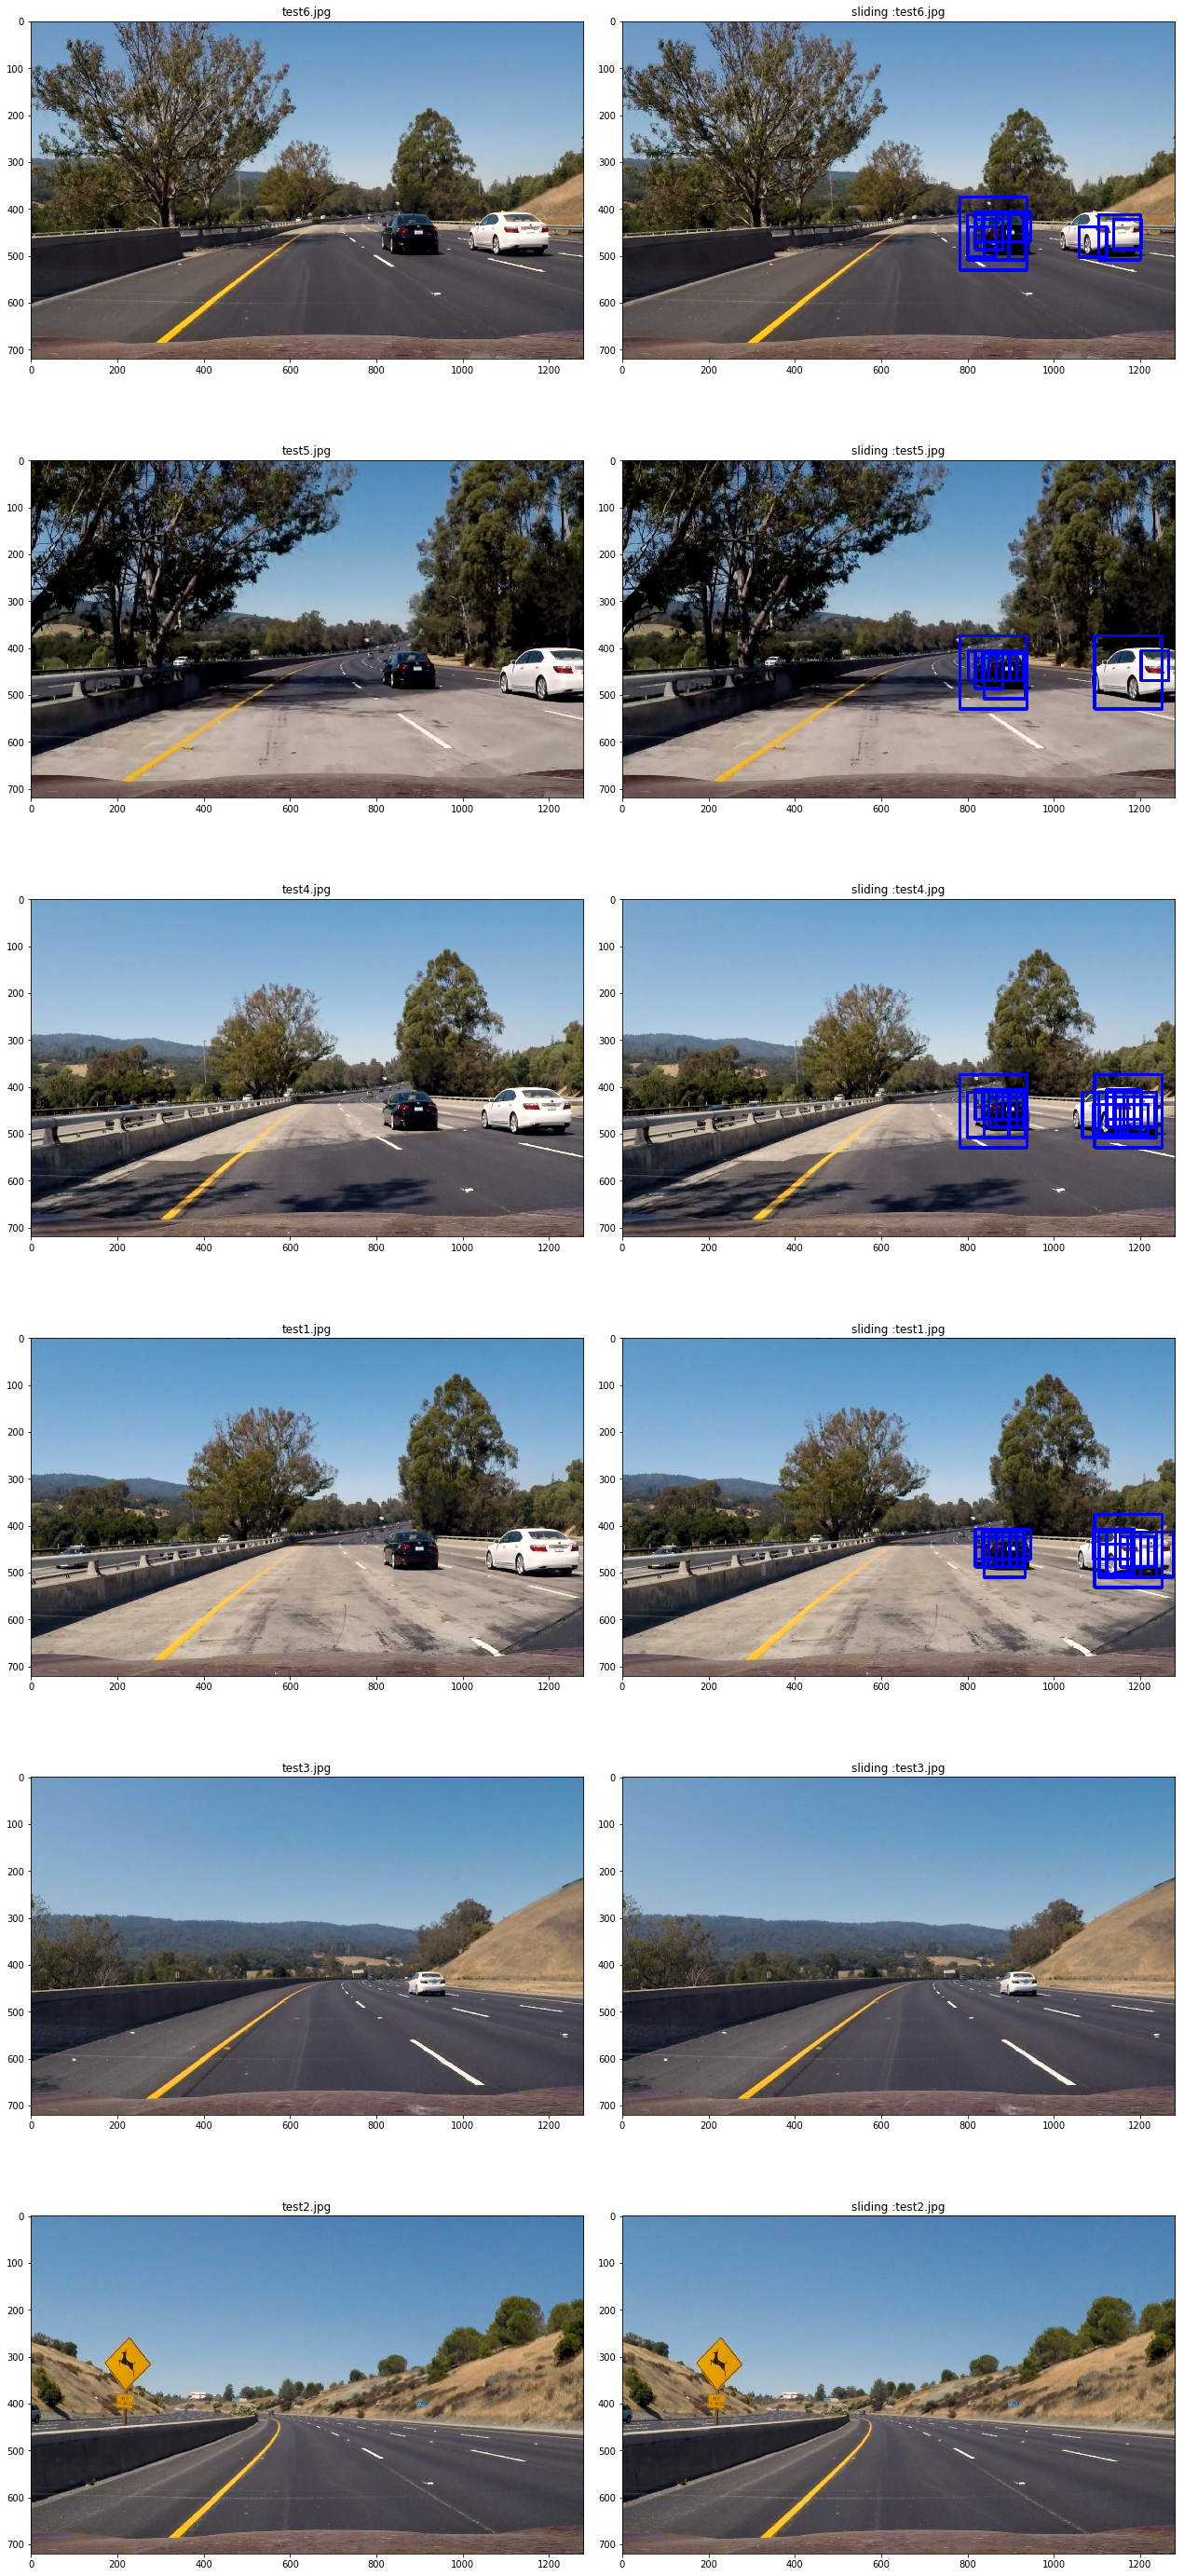

In [24]:
sliding_names = ["sliding :" + f for f in filenames]
images_list =  np.asarray(list( zip(test_images,find_car_windows) ))
images_label =  np.asarray(list( zip( filenames, sliding_names  ) ))
showImageList(images_list, images_label,cols=2,fig_size=(22, 50) )

## HOG sub sampling searching window

In [40]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [70]:
def find_cars(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                        hist_bins, test_flag=True, windows_flag=False, heat_flag=False):
    
    img_orig = np.copy(img)
    draw_img = np.copy(img)
    
    ## convert jpg for test images
    if test_flag:
        img = draw_img.astype(np.float32)/255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    
    ## test 
    plt.figure(figsize=(14,8))
    plt.imshow(img_tosearch)
    plt.show()
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # test
    ch1 = ctrans_tosearch[:,:,0]
    print("shrink ch1 size..",ch1.shape)
    plt.figure(figsize=(14,8))
    plt.imshow(ch1)
    plt.show()
    

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    print(" nxblocks,nyblocks,nfeat_per_block ", nxblocks, nyblocks, nfeat_per_block )
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    print("nblocks_per_window,nxsteps,nysteps ..", nblocks_per_window,nxsteps,nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #test
    print(hog1.shape)
        
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            #print("hog1 feature..", ypos, ypos+nblocks_per_window, xpos , xpos+nblocks_per_window)
            
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            spatial_features = bin_spatial(subimg, color_space="YCrCb", size=spatial_size)
            
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)
            #print(hog_feat1.shape, spatial_features.shape,hist_features.shape)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bbox = ((xbox_left, ytop_draw+y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]))

                ## store the bounding box if its a car
                hot_windows.append(bbox)
                cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6)
            
    return draw_img

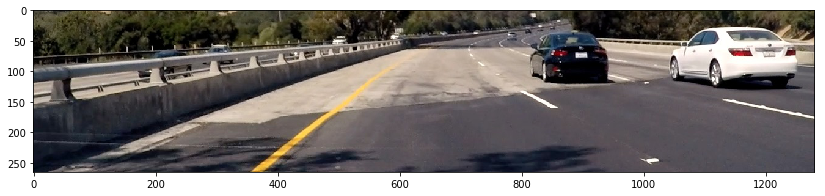

shrink ch1 size.. (265, 1280)


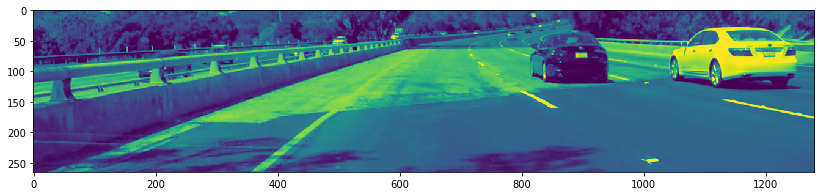

 nxblocks,nyblocks,nfeat_per_block  159 32 32
nblocks_per_window,nxsteps,nysteps .. 7 76 12
(32, 159, 2, 2, 8)


/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [71]:
y_start_stop = [375, 640]
scale = 1
#clf = rf_final
X_scaler = X_scaler
orient = 8
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
test_flag = True
windows_flag = True
heat_flag = False
output_img = find_cars(test_images[2], y_start_stop, scale, rf, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, test_flag, windows_flag, heat_flag)

In [69]:
plt.figure(figsize=(14,8))
plt.imshow(output_img)

## another approach to show box

In [ ]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    

In [88]:
from scipy.ndimage.measurements import label
print(" test image size .." , test_images[0].shape)

print(" Start to seach car with sliding window technique ....")

find_car_windows = []
for image in test_images:
    #window_list = slide_window(image, x_start_stop, y_start_stop)
    window_list = build_multiple_windows(image)
    #
    # YCrCb / need full 3 channels used for HOG features
    #  
    hot_windows = search_windows(image, window_list, clf, X_scaler, color_space='YCrCb', 
                spatial_size=(32, 32), hist_bins=32, 
                hist_range=(0, 256), orient=9, 
                pix_per_cell=8, cell_per_block=2, 
                hog_channel=3, spatial_feat=True, 
                hist_feat=True, hog_feat=True)
    
    #print(" window list length ..",  len( window_list ))

    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    
    window_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)             
    find_car_windows.append( window_img )


 test image size .. (720, 1280, 3)
 Start to seach car with sliding window technique ....


NameError: name 'build_multiple_windows' is not defined

In [18]:
plt.imshow(find_car_windows[0])

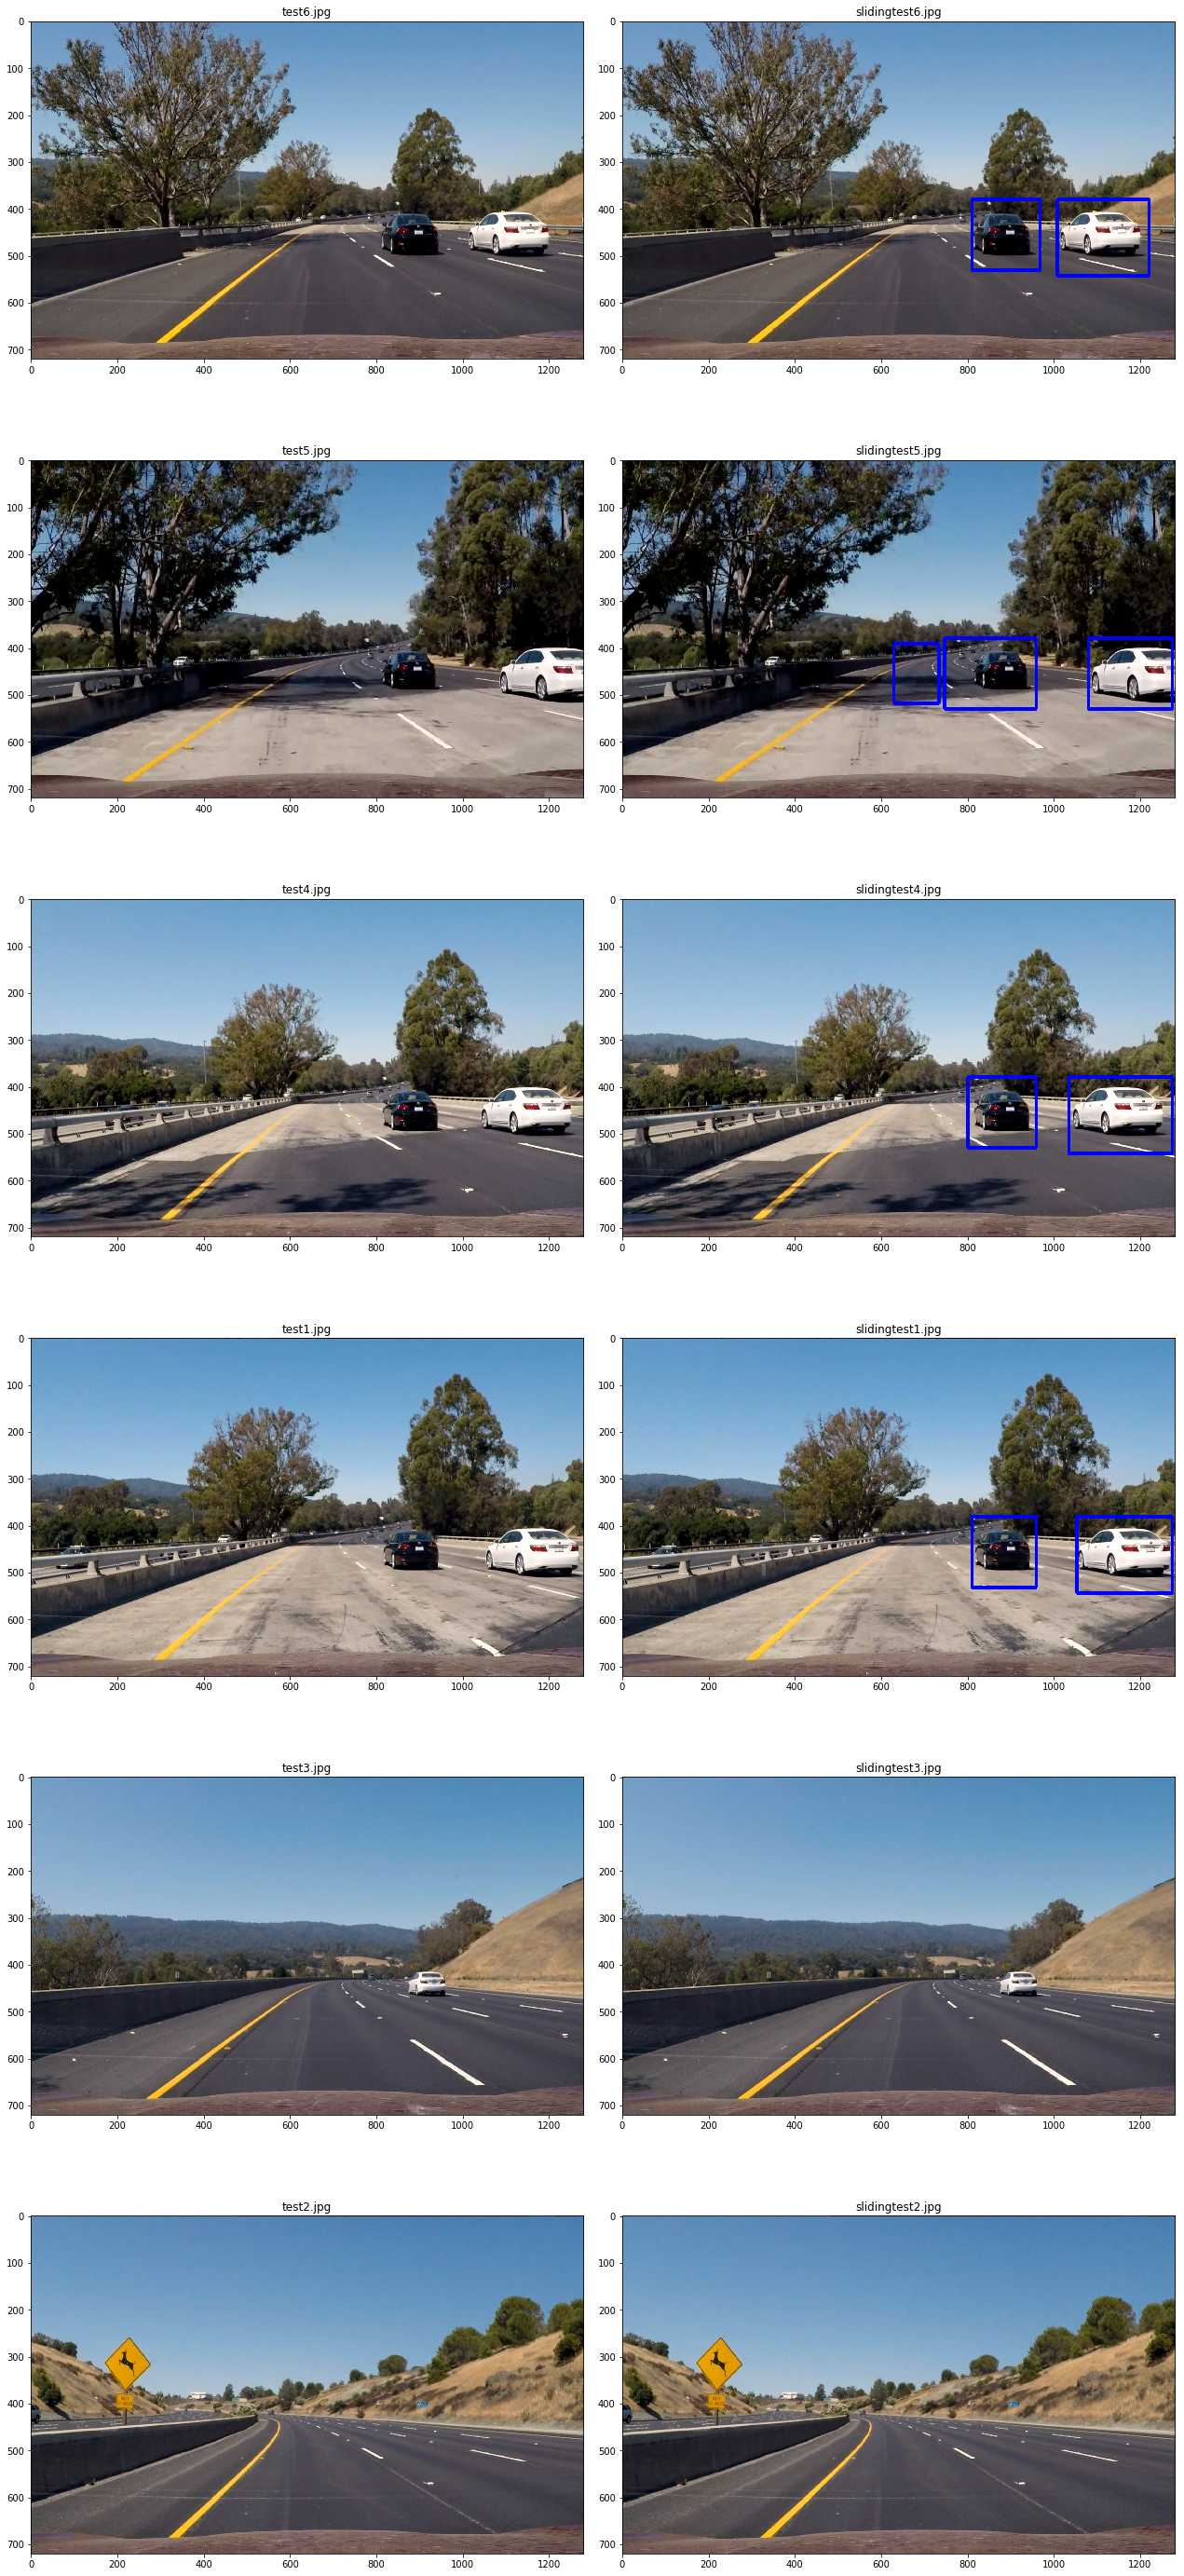

In [19]:
sliding_names = ["sliding" + f for f in filenames]

images_list =  np.asarray(list( zip(test_images,find_car_windows) ))
images_label =  np.asarray(list( zip( filenames, sliding_names  ) ))
showImageList(images_list, images_label,cols=2,fig_size=(22, 50) )

In [12]:
#
# Add heat map to omit false positives 
#
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [114]:



def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, color_space="YCrCb" ,size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)
            
            print(hog_features.shape, spatial_features.shape,hist_features.shape)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
    
out_img = find_cars(test_images[0], ystart, ystop, scale, rf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


(1764,) (768,) (96,)


/Users/donchan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: operands could not be broadcast together with shapes (1,2628) (2432,) (1,2628) 

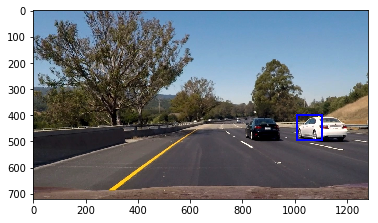

In [18]:
plt.imshow(out_img)